In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.util import ngrams
from string import punctuation
import re
from tqdm import tqdm_notebook
import numpy as np

In [2]:
import nltk
import itertools

In [3]:
# catalogo olenka

url = 'https://s3.amazonaws.com/catalog.download/olenka-wobiz-catalogo-de-productos-5bddb8462a5359718fecd498ffcf655b.csv'
catalogo = pd.read_csv(url)

catalogo.fillna('nada',inplace=True)

catalogo['TITLE'] = [x.lower() for x in catalogo.TITLE]
catalogo['DESCRIPTION'] = [x.lower() for x in catalogo.DESCRIPTION]

# tokenizer y lista de las palabras de olenka

catalogo['tokenized_title'] = catalogo.apply(lambda row: nltk.word_tokenize(row['TITLE']), axis=1)

tokens_catalogo_title = list(itertools.chain.from_iterable(catalogo['tokenized_title']))
#lst_phrases_catalogo = [phrase.replace(" ","_") for phrase in lst_tokens_catalogo]

# tokenizer y lista de las palabras de olenka

catalogo['tokenized_description'] = catalogo.apply(lambda row: nltk.word_tokenize(row['DESCRIPTION']), axis=1)

tokens_catalogo_description = list(itertools.chain.from_iterable(catalogo['tokenized_description']))
#lst_phrases_catalogo = [phrase.replace(" ","_") for phrase in lst_tokens_catalogo]

In [4]:
df = catalogo['TITLE']

df = pd.DataFrame(df)

df.columns = ['title']

# treveca 

In [84]:
df = pd.read_csv('product_catalog_cf88686e2ea6643ca230e005c18a4448 (2).csv')

df.title = [x.lower() for x in df.title]
df.description = [x.lower() for x in df.description]

df = pd.DataFrame(df.title,columns=['title'])

## Preprocesamiento

df = pd.read_csv('productos_joma.csv',index_col=0,names=["title"])

In [5]:
correcciones = {
    "plafã³n": "plafon",
    "inalã¡mbrico": "inalambrico"
}

In [6]:
def remove_punctuation(s):
    s = s.translate(str.maketrans('', '', punctuation))
    return re.sub(' +', ' ',s) #saco espacios repetidos

In [7]:
sws = stopwords.words("spanish")

In [8]:
def get_keywords(s):
    kws = []
    s = remove_punctuation(s.lower())
    for w in s.split():
        if w not in sws: kws.append(correcciones.get(w,w))
    return kws

In [9]:
df["keywords"] = df.title.apply(get_keywords)

In [10]:
n = 1

In [11]:
df[f"{n}-grams"] = df.keywords.apply(lambda kws: list([" ".join(x) for x in ngrams(kws,n)]))

In [12]:
df

,title,keywords,1-grams
0,blazer mariitte,"[blazer, mariitte]","[blazer, mariitte]"
1,maxi snake madness,"[maxi, snake, madness]","[maxi, snake, madness]"
2,falda dhil,"[falda, dhil]","[falda, dhil]"
3,necklace dnach,"[necklace, dnach]","[necklace, dnach]"
4,pulsera esvedra,"[pulsera, esvedra]","[pulsera, esvedra]"
5,t-shirt kitty,"[tshirt, kitty]","[tshirt, kitty]"
6,necklace pearls,"[necklace, pearls]","[necklace, pearls]"
7,skirt silvin,"[skirt, silvin]","[skirt, silvin]"
8,necklace teddy,"[necklace, teddy]","[necklace, teddy]"
9,maxi short pol,"[maxi, short, pol]","[maxi, short, pol]"


## Obtener trends

In [123]:
from pytrends.request import TrendReq

In [124]:
to_search = set()
for l in df[f"{n}-grams"]:
    [to_search.add(x) for x in l]

In [125]:
pytrend = TrendReq(hl='es-AR')

In [126]:
pytrend.build_payload(
    kw_list=["escritorio 1079"],
    cat=11,
    timeframe='today 3-m',
    geo='AR'
)

In [127]:
# AR-C es capital y AR-B es provincia de buenos aires

In [128]:
data = pytrend.interest_over_time()

In [129]:
data.empty

True

In [130]:
def is_relevant(data):
    # se define como relevante si al menos 50% de las filas son != 0
    if not data.empty:
        ratio = (data[data.columns[0]] != 0).sum()/len(data)
        return ratio >= 0.5
    return False

In [131]:
results = []
for w in tqdm_notebook(to_search):
    pytrend.build_payload(kw_list=[w],
         cat=11,
         timeframe='today 3-m',
         geo='AR'
    )
    data = pytrend.interest_over_time()
    if is_relevant(data): results.append(data.drop("isPartial",axis=1))
data = pd.concat(results,axis=1)

In [132]:
data

,conjunto,like,u,tom,jardinero,jean,flor,max,white,negro,...,top,gris,verde,cargo,pico,lino,lila,blanco,natural,disco
date,,,,,,,,,,,,,,,,,,,,,
2020-05-11,29,0,30,0,40,29,68,40,39,60,...,59,57,32,19,33,20,64,52,45,45
2020-05-12,34,39,18,31,41,65,44,51,87,48,...,30,59,76,40,26,32,33,52,67,44
2020-05-13,45,39,28,31,63,41,47,21,44,60,...,65,70,48,30,52,21,0,54,57,36
2020-05-14,68,0,25,32,63,36,69,35,24,67,...,46,79,41,41,53,22,34,43,51,34
2020-05-15,39,41,38,33,87,31,39,42,46,57,...,68,57,46,21,18,34,52,50,46,32
2020-05-16,56,97,53,39,52,47,79,25,29,72,...,61,96,77,33,21,53,62,54,58,72
2020-05-17,43,49,70,40,53,38,76,43,37,81,...,58,75,74,26,21,40,0,58,76,59
2020-05-18,51,0,24,31,0,69,92,27,34,69,...,45,78,46,39,34,42,32,63,56,48
2020-05-19,22,58,55,0,41,65,73,20,52,63,...,41,59,76,20,25,21,0,57,66,66


In [133]:
results

[            conjunto
 date                
 2020-05-11        29
 2020-05-12        34
 2020-05-13        45
 2020-05-14        68
 2020-05-15        39
 2020-05-16        56
 2020-05-17        43
 2020-05-18        51
 2020-05-19        22
 2020-05-20        22
 2020-05-21        30
 2020-05-22        92
 2020-05-23        46
 2020-05-24        48
 2020-05-25        26
 2020-05-26        22
 2020-05-27        46
 2020-05-28        68
 2020-05-29        46
 2020-05-30        34
 2020-05-31        64
 2020-06-01        36
 2020-06-02        45
 2020-06-03        43
 2020-06-04        22
 2020-06-05        33
 2020-06-06        82
 2020-06-07        85
 2020-06-08        31
 2020-06-09        21
 ...              ...
 2020-07-10        43
 2020-07-11        30
 2020-07-12        31
 2020-07-13        25
 2020-07-14        64
 2020-07-15        26
 2020-07-16        76
 2020-07-17        53
 2020-07-18        45
 2020-07-19        32
 2020-07-20        40
 2020-07-21        39
 2020-07-2

data.to_csv('datos_gt_joma.csv')

In [134]:
data.to_csv('datos_gt_treveca_1ngram.csv')

## Analisis

In [15]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.util import ngrams
from string import punctuation
import re
from tqdm import tqdm_notebook
import numpy as np

import nltk
import itertools

In [6]:
data=pd.read_csv('datos_gt_treveca_1ngram.csv',index_col='date')

In [7]:
intervals = [60,30,15,7]

### Promedio

In [8]:
def get_means(data,days):
    s = data.apply(lambda s: s[-days:].mean())
    s.name = f"{days}_day_mean"
    return s

In [9]:
pd.concat((get_means(data,days) for days in intervals),axis=1)

,60_day_mean,30_day_mean,15_day_mean,7_day_mean
conjunto,44.250000,43.466667,46.533333,35.714286
like,31.400000,34.000000,30.200000,27.428571
u,33.700000,34.200000,37.200000,31.428571
tom,30.866667,38.333333,37.066667,34.571429
jardinero,25.533333,25.966667,21.866667,18.571429
jean,40.933333,42.233333,40.600000,40.000000
flor,60.133333,64.166667,64.866667,61.428571
max,37.650000,37.500000,39.933333,32.285714
white,40.750000,40.733333,41.400000,40.000000
negro,65.816667,67.666667,69.133333,61.142857


### Tendencias

#### Scoring

In [10]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [11]:
def get_slope(series,days):
    # Pendiente de la recta que mejor ajusta los puntos de los ultimos {days} dias
    model = LinearRegression()
    X = np.array(range(days)).reshape(-1, 1) # 0,1..{days-1}
    y = series[-days:]
    model.fit(X,y)
    return model.coef_[0]

In [12]:
def get_scores(data,days):
    s = data.apply(lambda s: get_slope(s,days))
    s.name = f"{days}_day_score"
    return s

In [16]:
results = []
for days in intervals:
    results.append(get_scores(data,days))
scores = pd.concat(results,axis=1)

In [14]:
def get_final_score(row):
    # promedio ponderado de los scores para cada intervalo de tiempo
    return (0.3*row["60_day_score"] + 0.3*row["30_day_score"] + 0.3*row["15_day_score"] + 0.1*row["7_day_score"])/4

In [18]:
scores["final"] = scores.apply(get_final_score,axis=1)

In [19]:
scores.sort_values("final",ascending=False)

,60_day_score,30_day_score,15_day_score,7_day_score,final
medias,0.144040,0.330367,1.235714,9.107143,0.355938
aros,0.300278,0.273637,1.753571,5.857143,0.320990
cordon,0.417616,0.372191,2.603571,1.392857,0.289325
jardinero,0.043623,0.031813,0.650000,3.071429,0.131193
paris,-0.052292,-0.093215,0.678571,3.035714,0.115873
boton,-0.145985,-0.838042,0.625000,4.250000,0.079323
carol,0.189358,-0.691212,-0.785714,6.678571,0.070397
flor,0.141095,0.225806,-0.335714,1.750000,0.046089
tom,0.398333,-0.022247,-0.553571,2.107143,0.039367
lino,0.003529,0.142825,-0.553571,2.321429,0.027494


#### Plot

In [20]:
ej = data["medias"]

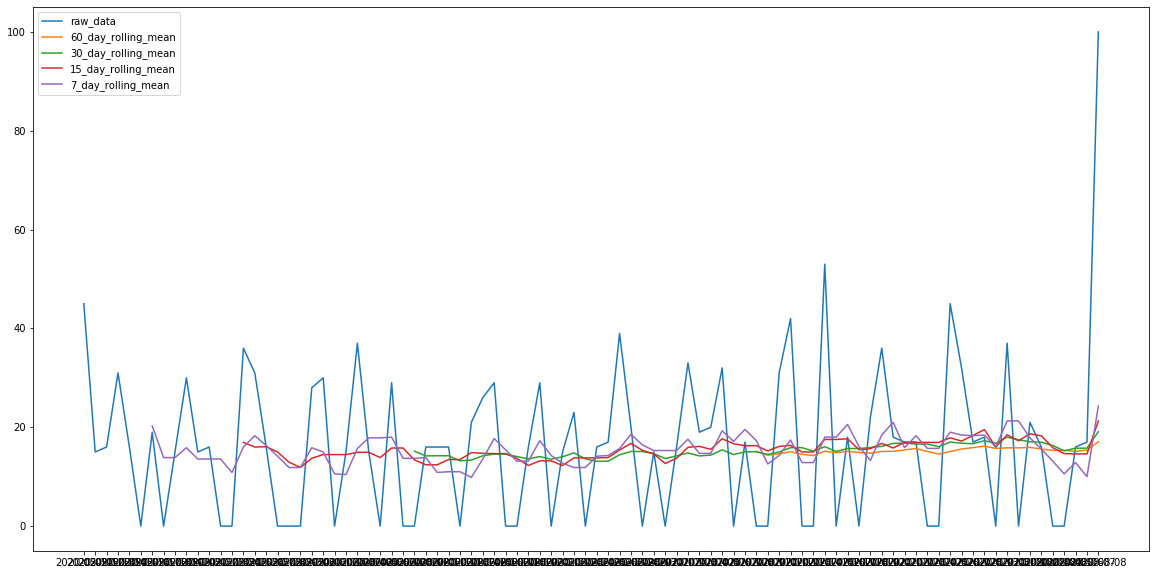

In [21]:
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(ej,label="raw_data")
for d in intervals: ax.plot(ej.rolling(d).mean(),label=f"{d}_day_rolling_mean")
plt.legend()
plt.show()

In [156]:
ej = data["aros"]

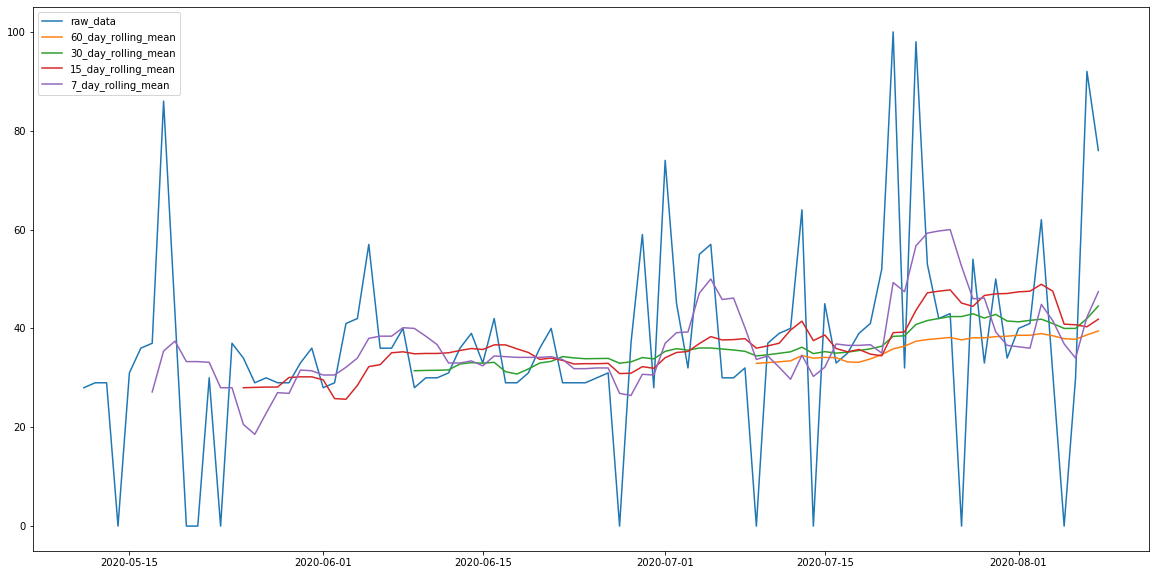

In [157]:
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(ej,label="raw_data")
for d in intervals: ax.plot(ej.rolling(d).mean(),label=f"{d}_day_rolling_mean")
plt.legend()
plt.show()